In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dat=pd.read_csv('solve_data.csv')
dat=dat.iloc[:,1:]
# print(dat.head())
print(dat.shape)

## 查看有无空值
print(dat.isnull().any().any())
# print(dat.isnull().sum())
# dat.describe()

(2158, 44)
False


In [2]:
## 数据规范化处理
xdata = dat[['S2','S3t1','S4','B2','B3','B4','B5','S6','S7','S9','S11','F1','H2','H4','H5','E4','E1','E6']]
#对xdata进行标准化处理
Sdata = xdata.apply(lambda x:(x-x.mean())/x.std())
print(Sdata.shape)
Sdata.head()

(2158, 18)


,S2,S3t1,S4,B2,B3,B4,B5,S6,S7,S9,S11,F1,H2,H4,H5,E4,E1,E6
0,1.170823,0.580083,-2.168219,-1.039095,0.924552,0.706826,2.964211,-0.054477,1.409201,1.631070,-0.996955,1.011887,1.270194,0.823337,-0.180522,1.410846,-0.856527,-0.862808
1,1.170823,-0.054392,-0.872452,1.858460,-0.083625,-2.490933,-0.519488,-0.724345,1.409201,-0.733096,0.383936,1.011887,-1.299367,-0.674144,-0.180522,0.284049,0.090877,-0.862808
2,1.170823,0.976629,-1.520335,1.858460,-2.099979,0.706826,3.660951,-0.724345,1.409201,-0.733096,-0.996955,-0.987795,-1.299367,-0.674144,1.948255,1.410846,0.090877,1.202572
3,1.170823,0.024917,-0.872452,-0.016428,-1.091802,-1.691493,-0.519488,-0.054477,-0.910091,0.054959,-0.996955,1.011887,-1.299367,0.074596,0.883866,0.284049,-0.856527,2.235262
4,-0.847257,-0.133701,0.423316,-0.868651,-0.083625,-0.092614,-0.519488,-0.054477,-0.446233,0.843015,0.383936,1.011887,0.199544,-1.422884,-1.244910,0.284049,0.090877,1.202572


## 因子分析

In [ ]:
## 因子分析，为验证样本的可行性，首先对样本数据进行KMO和巴特利特检验
from factor_analyzer import factor_analyzer,Rotator
from factor_analyzer import FactorAnalyzer

# KMO值
print(round(factor_analyzer.calculate_kmo(Sdata)[1], 3))

# 巴特利特球形度值
print(round(factor_analyzer.calculate_bartlett_sphericity(Sdata)[1], 3))

## 从上图可知：KMO检验中，其KMO的概率值为0.635,变量间的偏相关性较一般强，可以进行因子分析。巴特利特球形度检验检验中，
## 其伴随概率为0.00小于显著水平5%，说明这些变量可以进行因子分析。

In [ ]:
## 计算Sdata的相关系数矩阵
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18, 8)

corr = Sdata.corr()
# 相关度热力图
sns.heatmap(corr, cmap='GnBu_r', square=True, annot=True)

In [ ]:
#查看相关矩阵特征值
fa = FactorAnalyzer(18, rotation='varimax',method='principal',impute='mean')
fa.fit(Sdata)
ev, v = fa.get_eigenvalues()
print('相关矩阵特征值：',ev)

#Create scree plot using matplotlib
plt.figure(figsize=(8, 6.5))
plt.scatter(range(1,Sdata.shape[1]+1),ev)
plt.plot(range(1,Sdata.shape[1]+1),ev)
plt.title('Gravel map ',fontdict={'weight':'normal','size': 25})
plt.xlabel('factor',fontdict={'weight':'normal','size': 15})
plt.ylabel('Eigenvalues',fontdict={'weight':'normal','size': 15})
plt.grid()
# plt.savefig('E:/suishitu.jpg')
plt.show()

#确定因子个数(提取特征值大于1的因子)
n_factors = sum(ev>=1.2)
n_factors    #为4因子

In [ ]:
#取4个因子旋转后的结果
fa2 = FactorAnalyzer(n_factors,rotation='varimax',method='principal')
fa2.fit(Sdata)

#给出贡献率
var = fa2.get_factor_variance()

#计算因子得分
fa2_score = fa2.transform(Sdata)

#方差贡献表
df_fv = pd.DataFrame()
df_fv['因子'] = column_list
df_fv['方差贡献'] = var[1]
df_fv['累计方差贡献'] = var[2]     #4个主成分的累计方差贡献为0.411629
df_fv['累计方差贡献占比'] = var[1]/var[1].sum()
print("\n方差贡献表:\n",df_fv) 

#因子得分表
column_list = ['fac'+str(i) for i in np.arange(n_factors)+1]
fa_score = pd.DataFrame(fa2_score,columns=column_list)
for col in fa_score.columns:
    dat[col] = fa_score[col]
print("\n各因子得分:\n",fa_score)    

In [ ]:
# 构造因子变量
rotator = Rotator()
fac_x = rotator.fit_transform(fa2.loadings_)
fac_x = pd.DataFrame(fac_x)
fac_x.columns=['factor1','factor2','factor3','factor4']
fac_x.index=['性别','年龄','家庭年收入','职业','教育水平','种族','宗教','购物目的','第一次使用时间','使用频率','购买时间','是否会多种乐器','上次购买方式','购买时长','喜欢购买方式','音乐兴趣','音乐平台','音乐app']
fac_x

fac_x = fac_x.sort_values(by='factor1',ascending=False)
fac_x

## 根据业务需要分类因子变量
#factor1: 第一次使用时间，使用频率，音乐兴趣,性别,购买方式，购买时长，上次购买方式    --专业度(Profe)
#factor2: 家庭年收入，教育水平，职业，购物目的    --家庭情况  家庭收入(Inc)
#factor3: 音乐app, 购买时间,音乐平台,       --业余音乐爱好者  兴趣 (Interes)
#factor4: 年龄，宗教，种族，是否会多种乐器       --个人信息  (Faith)

## k-mean 聚类

### 1.数据规范化处理

In [ ]:
dat

In [ ]:
## 数据规范化处理
from sklearn import preprocessing as pc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

c_dat = dat[['fac1','fac2','fac3','fac4','B1s1','B1s2','B1s3','B1s4','B1s5','B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15','B1s16','B1s17','B1s18','B1s19','B1s20']]
sc_dat = c_dat.apply(lambda x:(x-x.mean())/x.std())
print(sc_dat.shape)

### 2.计算sc_dat的相关系数矩阵

In [ ]:
## 计算Sdata的相关系数矩阵
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (25, 10)

# 相关度热力图
sns.heatmap(sc_dat.corr(), cmap='GnBu_r', square=True, annot=True)

### 3.选取最优聚类数k

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
 
SSE = []  # 存放每次结果的误差平方和
for k in range(1,15):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sc_dat)
    SSE.append(estimator.inertia_)
X = range(1,15)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('k-SSE') 
plt.plot(X,SSE,'o-')
plt.savefig('SSE.png')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

Scores = []  # 存放轮廓系数
for k in range(2,15):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sc_dat)
    Scores.append(silhouette_score(sc_dat,estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.xlabel('k')
plt.ylabel('轮廓系数')
plt.title('K-轮廓系数图') 
plt.plot(X,Scores,'o-')
plt.savefig('轮廓系数.png')
plt.show()

## k==6 分成7类

In [ ]:
import pandas as pd
#参数初始化
k = 6 #聚类的类别
iteration = 5 #聚类最大循环次数

from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, max_iter = iteration) #分为k类
#model = KMeans(n_clusters = k, n_jobs = 4, max_iter = iteration) #分为k类，并发数4
model.fit(sc_dat) #开始聚类

#简单打印结果
r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
print(r)
r.columns = list(sc_dat.columns) + [u'类别数目'] #重命名表头
print(r)

#详细输出原始数据及其类别
r = pd.concat([sc_dat, pd.Series(model.labels_, index =sc_dat.index)], axis = 1)  #详细输出每个样本对应的类别
r.columns = list(sc_dat.columns) + [u'聚类类别'] #重命名表头
# r.to_excel(outputfile) #保存结果
print(r)

In [ ]:
#用TSNE进行数据降维并展示聚类结果
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(sc_dat) #进行数据降维,并返回结果
tsne = pd.DataFrame(tsne.embedding_, index = sc_dat.index) #转换数据格式

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

#不同类别用不同颜色和样式绘图
d = tsne[r[u'聚类类别'] == 0]     #找出聚类类别为0的数据对应的降维结果
plt.plot(d[0], d[1], 'r*')
d = tsne[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
d = tsne[r[u'聚类类别'] == 3]
plt.plot(d[0], d[1], 'mo')
d = tsne[r[u'聚类类别'] == 4]
plt.plot(d[0], d[1], 'yo')
d = tsne[r[u'聚类类别'] == 5]
plt.plot(d[0], d[1], 'k*')
# d = tsne[r[u'聚类类别'] == 6]
# plt.plot(d[0], d[1], 'c*')

plt.savefig('kmeans.png')
plt.show()

In [ ]:
## 聚类结果分析
# 将聚类结果带入原始数据
c_dat["label"]=r['聚类类别']
result_avg=c_dat.groupby("label").mean()
result_avg=result_avg.join(c_dat.label.value_counts())
result_avg.columns=['fac1','fac2','fac3','fac4','B1s1','B1s2','B1s3','B1s4','B1s5','B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15','B1s16','B1s17','B1s18','B1s19','B1s20','count']
result_avg["rate"]=result_avg["count"]/sum(result_avg["count"])
result_avg[['count','rate']]
# result_avg.to_csv("分类结果.csv")

In [ ]:
result_avg[['count','rate']]

## kmeans聚类分析

In [ ]:
## 6类人群结果解读
# 第一类人群：
# 第二类人群：


## 决策树

In [ ]:
# c_dat
X = c_dat[['fac1','fac2','fac3','fac4','B1s1','B1s2','B1s3','B1s4','B1s5','B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15','B1s16','B1s17','B1s18','B1s19','B1s20']]
Y = c_dat['label']
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)
print(X.shape)
print(Y.shape)
print(Xtrain.shape)
print(Xtest.shape)

In [ ]:
clf = DecisionTreeClassifier(random_state=3) # 初始化
clf = clf.fit(Xtrain,Ytrain) # 拟合

# 分类准确率
score_ = clf.score(Xtest, Ytest) # 验证集查看得分
print(score_)

# 可以输入数据送到训练好的模型里，输出预测的类
y_pred = clf.predict(Xtest)
print(y_pred[:10])

#看特征变量的使用情况
# [*zip(feature_name,clf.feature_importances_)]

In [ ]:
#生成决策树
from sklearn.tree import DecisionTreeClassifier
#设置最大叶子数为8
dtModel = DecisionTreeClassifier(max_leaf_nodes=18) 

#模型检验－交叉验证法
from sklearn.model_selection import cross_val_score
print(cross_val_score(dtModel,X,Y,cv=10))

#训练模型
dtModel=dtModel.fit(X,Y) 

# tree模型可视化
import re
import pydotplus
from six import StringIO  #生成StringIO对象
from sklearn.tree import export_graphviz
# dot_data = StringIO() #把文件暂时写在内存的对象中
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

dot_data = export_graphviz(
    dtModel,
    out_file=None,
    class_names=['1','2','3','4','5','6'],
#     feature_names=['fac1','fac2','fac3','fac4','B1s1','B1s2','B1s3','B1s4','B1s5','B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15','B1s16','B1s17','B1s18','B1s19','B1s20'],
    feature_names=['专业度','收入','兴趣','信仰','质量','定制化','新潮','简约','传统','归属感','刺激','自然','服务','自由自在','激情','高尚','科技','活力','进取','明智购物','个人效率','古典','安逸','全面成本'],
    filled=True,rounded=True,special_characters=True
)

with open("dot_data.dot", 'w+', encoding="utf-8-sig") as f:  # 注意编码方式
    f.writelines(dot_data)
    
# 打开 dot_data.dot，修改 fontname="支持的中文字体"
f = open("dot_data.dot",  encoding="utf-8-sig")
open('dot_test.dot', 'w+', encoding="utf-8-sig").write(re.sub(r'fontname=helvetica', 'fontname="Microsoft YaHei"', f.read()))

with open("dot_test.dot",  encoding="utf-8-sig") as fp:
    dot_test = fp.read()
    
graph = pydotplus.graph_from_dot_data(dot_test)  #.getvalue()
graph.write_png('tree.png')

In [ ]:
## 根据业务需要分类因子变量
#factor1: 第一次使用时间，使用频率，音乐兴趣,性别,购买方式，购买时长，上次购买方式    --专业度(Profe)
#factor2: 家庭年收入，教育水平，职业，购物目的    --家庭情况  家庭收入(Inc)
#factor3: 音乐app, 购买时间,音乐平台,       --业余音乐爱好者  兴趣 (Interes)
#factor4: 年龄，宗教，种族，是否会多种乐器       --个人信息  (Faith)

# ['专业度','收入','兴趣','信仰','质量','定制化','新潮','简约','传统','归属感','刺激','自然','服务','自由自在','激情','高尚','科技','活力','进取','明智购物','个人效率','古典','安逸','全面成本']

## 直接聚类

In [14]:
raw = dat[['S2','S3t1','S4','B2','B3','B4','B5','S6','S7','S9','S11','F1','H2','H4','H5','E4','num','level']]

# raw=dat.drop(dat[['E1','E6','NO','S1','U1','U3']],axis=1)
print(raw.shape)

s_raw = raw.apply(lambda x:(x-x.mean())/x.std())
# print(s_raw.describe())
s_raw.head()

(2158, 18)


,S2,S3t1,S4,B2,B3,B4,B5,S6,S7,S9,S11,F1,H2,H4,H5,E4,num,level
0,1.170823,0.580083,-2.168219,-1.039095,0.924552,0.706826,2.964211,-0.054477,1.409201,1.631070,-0.996955,1.011887,1.270194,0.823337,-0.180522,1.410846,0.352189,-1.020187
1,1.170823,-0.054392,-0.872452,1.858460,-0.083625,-2.490933,-0.519488,-0.724345,1.409201,-0.733096,0.383936,1.011887,-1.299367,-0.674144,-0.180522,0.284049,-0.525436,1.559266
2,1.170823,0.976629,-1.520335,1.858460,-2.099979,0.706826,3.660951,-0.724345,1.409201,-0.733096,-0.996955,-0.987795,-1.299367,-0.674144,1.948255,1.410846,-0.525436,-1.020187
3,1.170823,0.024917,-0.872452,-0.016428,-1.091802,-1.691493,-0.519488,-0.054477,-0.910091,0.054959,-0.996955,1.011887,-1.299367,0.074596,0.883866,0.284049,-0.525436,-1.020187
4,-0.847257,-0.133701,0.423316,-0.868651,-0.083625,-0.092614,-0.519488,-0.054477,-0.446233,0.843015,0.383936,1.011887,0.199544,-1.422884,-1.244910,0.284049,0.352189,-1.020187


<AxesSubplot:>

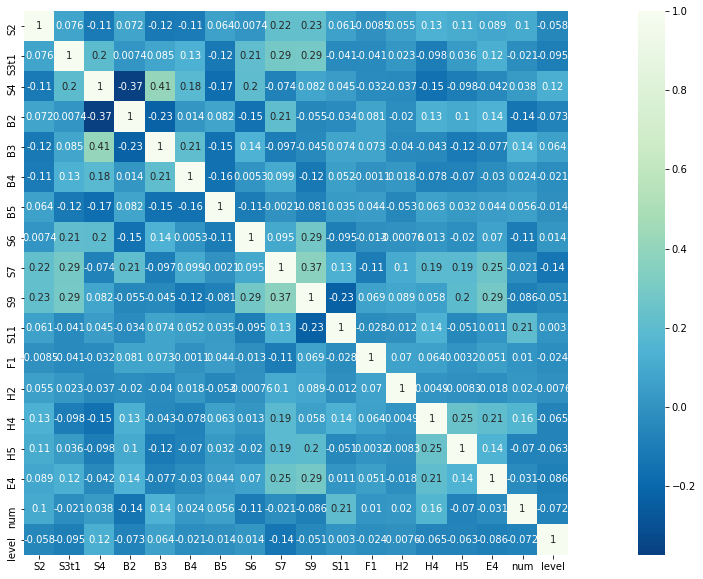

In [12]:
## 计算Sdata的相关系数矩阵
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (25, 10)

# 相关度热力图
sns.heatmap(s_raw.corr(), cmap='GnBu_r', square=True, annot=True)

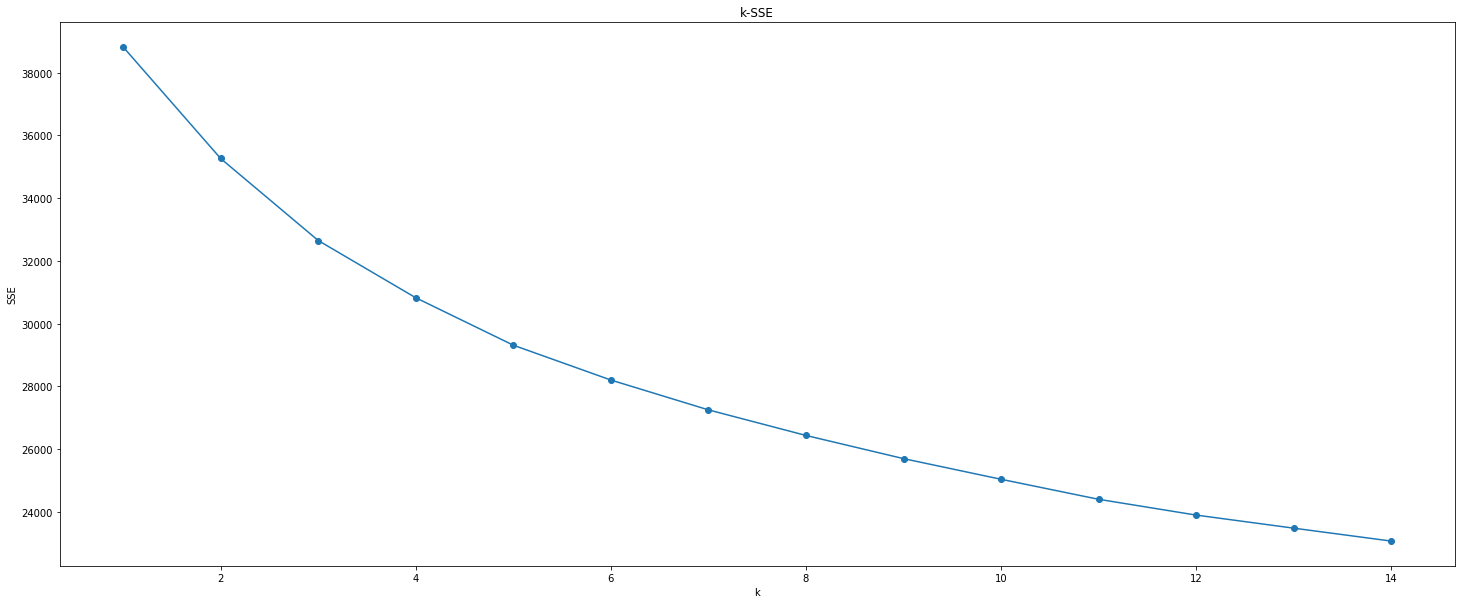

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
 
SSE = []  # 存放每次结果的误差平方和
for k in range(1,15):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(s_raw)
    SSE.append(estimator.inertia_)
X = range(1,15)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('k-SSE') 
plt.plot(X,SSE,'o-')
plt.savefig('SSE.png')
plt.show()

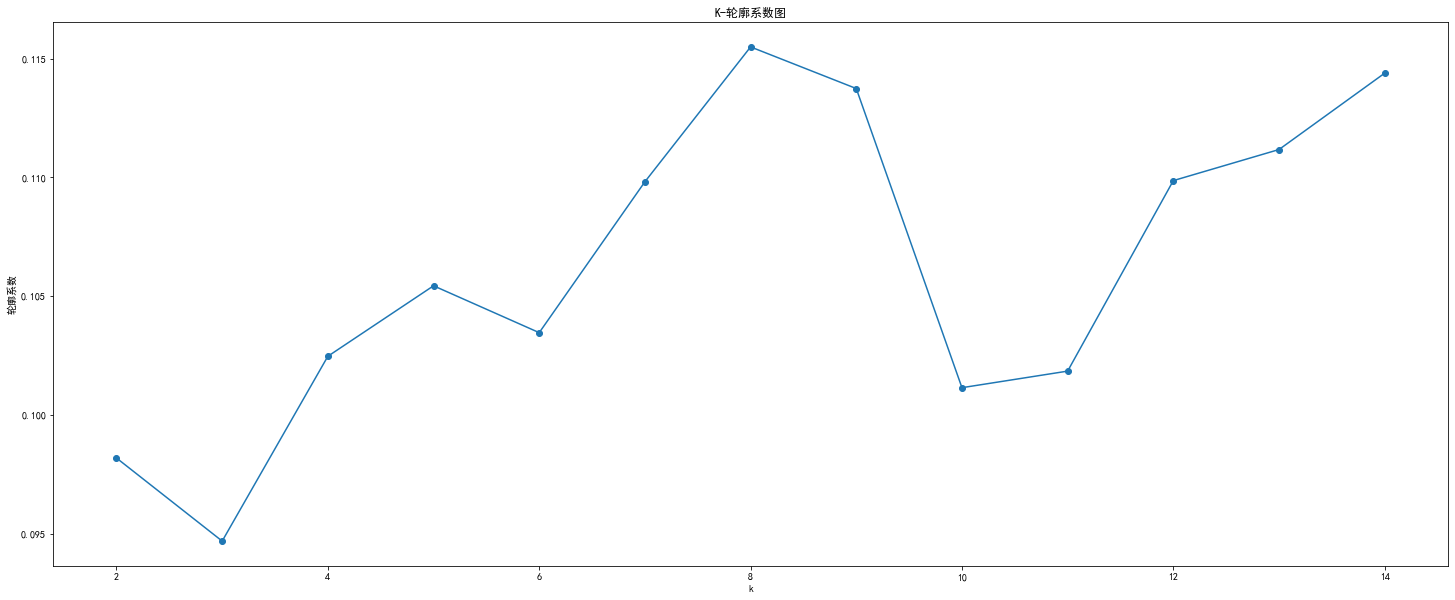

In [16]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

Scores = []  # 存放轮廓系数
for k in range(2,15):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(s_raw)
    Scores.append(silhouette_score(s_raw,estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.xlabel('k')
plt.ylabel('轮廓系数')
plt.title('K-轮廓系数图') 
plt.plot(X,Scores,'o-')
plt.savefig('轮廓系数.png')
plt.show()

## k==8 分成8类

In [17]:
import pandas as pd
#参数初始化
k = 8 #聚类的类别
iteration = 5 #聚类最大循环次数

from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, max_iter = iteration) #分为k类
#model = KMeans(n_clusters = k, n_jobs = 4, max_iter = iteration) #分为k类，并发数4
model.fit(s_raw) #开始聚类

#简单打印结果
r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
print(r)
r.columns = list(s_raw.columns) + [u'类别数目'] #重命名表头
print(r)

#详细输出原始数据及其类别
r = pd.concat([s_raw, pd.Series(model.labels_, index =s_raw.index)], axis = 1)  #详细输出每个样本对应的类别
r.columns = list(s_raw.columns) + [u'聚类类别'] #重命名表头
# r.to_excel(outputfile) #保存结果
print(r)

         0         1         2         3         4         5         6   \
0  0.248654 -0.128449 -0.310380  0.295112 -0.524286 -0.224971  2.964211   
1 -0.267477 -0.318829  0.464480 -0.194877  0.476163  0.576531 -0.292374   
2  0.313400  1.241268 -0.953017  1.434557 -0.830617  0.503860 -0.270394   
3  0.361174 -0.074338  0.151748 -0.711474  0.616665  0.113230  0.164736   
4  0.196052 -0.997425 -1.376090  0.551505 -1.034736 -1.130377  0.030017   
5 -0.031322  0.800909  0.578738 -0.635725  0.196273 -0.277928 -0.476294   
6 -0.626529 -0.184096  0.220852 -0.011546  0.289190  0.267551 -0.212850   
7  0.523514 -0.205529  0.386643 -0.143136  0.205512  0.034090 -0.251309   

         7         8         9         10        11        12        13  \
0 -0.152074  0.134358 -0.125093  0.063862 -0.021061 -0.164903 -0.009699   
1 -0.586485 -0.172018 -0.680849  0.403009 -0.971223 -0.279587 -0.293569   
2 -0.207193  1.274610  0.471445 -0.016737  0.131198  0.359309  0.291848   
3 -0.361333 -0.290687 -0

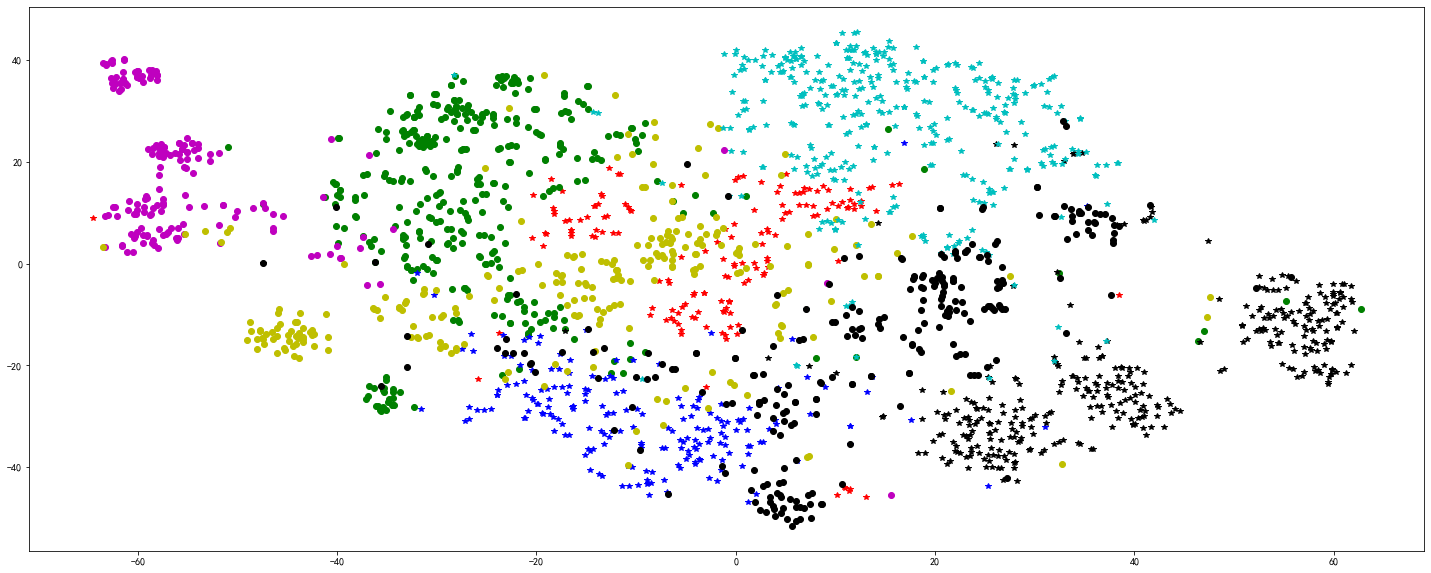

In [19]:
#用TSNE进行数据降维并展示聚类结果
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(s_raw) #进行数据降维,并返回结果
tsne = pd.DataFrame(tsne.embedding_, index = s_raw.index) #转换数据格式

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

#不同类别用不同颜色和样式绘图
d = tsne[r[u'聚类类别'] == 0]     #找出聚类类别为0的数据对应的降维结果
plt.plot(d[0], d[1], 'r*')
d = tsne[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
d = tsne[r[u'聚类类别'] == 3]
plt.plot(d[0], d[1], 'mo')
d = tsne[r[u'聚类类别'] == 4]
plt.plot(d[0], d[1], 'yo')
d = tsne[r[u'聚类类别'] == 5]
plt.plot(d[0], d[1], 'k*')
d = tsne[r[u'聚类类别'] == 6]
plt.plot(d[0], d[1], 'c*')
d = tsne[r[u'聚类类别'] == 7]
plt.plot(d[0], d[1], 'ko')

plt.savefig('kmeans.png')
plt.show()

In [22]:
## 聚类结果分析
# 将聚类结果带入原始数据
raw["label"]=r['聚类类别']
result_avg=raw.groupby("label").mean()
result_avg=result_avg.join(raw.label.value_counts())
# result_avg.columns=['S2', 'S3t1', 'S4', 'B2', 'B3', 'B4', 'B5', 'S6', 'S7', 'S9', 'S11',
#        'F1', 'H2', 'H4', 'H5', 'E4', 'B1s1', 'B1s2', 'B1s3',
#        'B1s4', 'B1s5', 'B1s6', 'B1s7', 'B1s8', 'B1s9', 'B1s10', 'B1s11',
#        'B1s12', 'B1s13', 'B1s14', 'B1s15', 'B1s16', 'B1s17', 'B1s18', 'B1s19',
#        'B1s20', 'num', 'level','count']
result_avg["rate"]=result_avg["label"]/sum(result_avg["label"])
result_avg[['label','rate']]
# result_avg.to_csv("分类结果.csv")

,label,rate
label,,
0,155,0.071826
1,366,0.169601
2,197,0.091288
3,166,0.076923
4,259,0.120019
5,364,0.168675
6,383,0.177479
7,268,0.124189


## 直接聚类结果进行决策树

In [23]:
raw

,S2,S3t1,S4,B2,B3,B4,B5,S6,S7,S9,S11,F1,H2,H4,H5,E4,num,level,label
0,2,48,2,2,5,5,6,3,7,8.0,5,2.0,13,4,2,3,2,1,0
1,2,40,4,19,4,1,1,1,7,2.0,6,2.0,1,2,2,2,1,3,4
2,2,53,3,19,2,5,7,1,7,2.0,5,1.0,1,2,4,3,1,1,0
3,2,41,4,8,3,2,1,3,2,4.0,5,2.0,1,3,3,2,1,1,4
4,1,39,6,3,4,4,1,3,3,6.0,6,2.0,8,1,1,2,2,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,2,28,6,3,5,3,1,10,3,4.0,6,2.0,13,3,3,1,1,2,7
2154,1,40,7,3,5,5,1,1,2,2.0,6,1.0,5,2,2,2,1,2,1
2155,2,49,7,4,4,3,1,3,4,8.0,5,1.0,12,3,3,2,2,1,5
2156,2,59,7,3,5,5,1,1,5,5.0,7,1.0,10,4,2,2,1,3,1


In [24]:
# c_dat
X = raw.drop(['label'],axis=1)
Y = raw['label']
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
print(X.shape)
print(Y.shape)
print(Xtrain.shape)
print(Xtest.shape)

(2158, 18)
(2158,)
(1726, 18)
(432, 18)


In [25]:
clf = DecisionTreeClassifier(random_state=3) # 初始化
clf = clf.fit(Xtrain,Ytrain) # 拟合

# 分类准确率
score_ = clf.score(Xtest, Ytest) # 验证集查看得分
print(score_)

# 可以输入数据送到训练好的模型里，输出预测的类
y_pred = clf.predict(Xtest)
print(y_pred[:10])

#看特征变量的使用情况
# [*zip(feature_name,clf.feature_importances_)]

0.8472222222222222
[1 7 0 0 0 7 4 5 4 2]


In [26]:
#生成决策树
from sklearn.tree import DecisionTreeClassifier
#设置最大叶子数为8
dtModel = DecisionTreeClassifier(max_leaf_nodes=12) 

#模型检验－交叉验证法
from sklearn.model_selection import cross_val_score
print(cross_val_score(dtModel,X,Y,cv=10))

#训练模型
dtModel=dtModel.fit(X,Y) 

[0.65277778 0.72685185 0.68055556 0.77314815 0.77314815 0.73148148
 0.78240741 0.76388889 0.7627907  0.80930233]


In [27]:
# tree模型可视化
import re
import pydotplus
from six import StringIO  #生成StringIO对象
from sklearn.tree import export_graphviz
# dot_data = StringIO() #把文件暂时写在内存的对象中
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

dot_data = export_graphviz(
    dtModel,
    out_file=None,
    class_names=['0','1','2','3','4','5','6','7'],
    feature_names=['性别', '年龄', '家庭年收入', '职业', '教育水平', '种族', '宗教信仰', '上次为谁购买', '第一次演奏乐器时间', '多久弹奏一次', '哪一年购买乐器',
       '是否可以演奏多种乐器', '上次在哪里购买', '购物思考时间', '购物方式', '音乐APP', '购买乐器数量', '乐器支出等级'],
#     feature_names=['专业度','收入','兴趣','信仰','质量','定制化','新潮','简约','传统','归属感','刺激','自然','服务','自由自在','激情','高尚','科技','活力','进取','明智购物','个人效率','古典','安逸','全面成本'],
    filled=True,rounded=True,special_characters=True
)

with open("dot_data.dot", 'w+', encoding="utf-8-sig") as f:  # 注意编码方式
    f.writelines(dot_data)
    
# 打开 dot_data.dot，修改 fontname="支持的中文字体"
f = open("dot_data.dot",  encoding="utf-8-sig")
open('dot_test.dot', 'w+', encoding="utf-8-sig").write(re.sub(r'fontname=helvetica', 'fontname="Microsoft YaHei"', f.read()))

with open("dot_test.dot",  encoding="utf-8-sig") as fp:
    dot_test = fp.read()
    
graph = pydotplus.graph_from_dot_data(dot_test)  #.getvalue()
graph.write_pdf('raw_tree.pdf')

True

In [43]:
result_avg[['label','rate']]

,label,rate
label,,
0,155,0.071826
1,366,0.169601
2,197,0.091288
3,166,0.076923
4,259,0.120019
5,364,0.168675
6,383,0.177479
7,268,0.124189


In [44]:
dat['label']=raw['label']
# order = ['NO','S1','S2', 'S3t1', 'S4', 'B2', 'B3', 'B4', 'B5', 'S6', 'S7', 'S9', 'S11',
#         'F1', 'H2', 'H4', 'H5', 'E4','label']
label_raw = dat.drop(['num','level'],axis=1)

In [45]:
label_raw.to_csv('无新增4个变量+去除价值观8类数据.csv')

In [46]:
label_raw.head()

,NO,S1,S2,S3t1,S4,B2,B3,B4,B5,S6,...,B1s14,B1s15,B1s16,B1s17,B1s18,B1s19,B1s20,E1,E6,label
0,1000006,10,2,48,2,2,5,5,6,3,...,3,3,5,5,5,3,4,1,1,0
1,1000009,43,2,40,4,19,4,1,1,1,...,4,5,4,4,4,4,4,2,1,4
2,1000017,35,2,53,3,19,2,5,7,1,...,3,3,3,3,3,3,3,2,3,0
3,1000036,21,2,41,4,8,3,2,1,3,...,3,4,3,3,4,3,3,1,4,4
4,1000126,1,1,39,6,3,4,4,1,3,...,4,4,4,4,4,4,4,2,3,6
